In [1]:
import numpy as np
import heapq
import timm

import pickle
import json
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torch as ch

import PIL
from PIL import Image, ImageFont, ImageDraw, ImageOps
from matplotlib import pyplot as plt
from scipy.stats import norm 
import statistics

from trak import TRAKer

/mnt/xfs/home/annama/conda_envs/ffcv/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
timm.list_models('vit*', pretrained=True)

['vit_base_patch8_224.augreg2_in21k_ft_in1k',
 'vit_base_patch8_224.augreg_in21k',
 'vit_base_patch8_224.augreg_in21k_ft_in1k',
 'vit_base_patch8_224.dino',
 'vit_base_patch14_dinov2.lvd142m',
 'vit_base_patch16_224.augreg2_in21k_ft_in1k',
 'vit_base_patch16_224.augreg_in1k',
 'vit_base_patch16_224.augreg_in21k',
 'vit_base_patch16_224.augreg_in21k_ft_in1k',
 'vit_base_patch16_224.dino',
 'vit_base_patch16_224.mae',
 'vit_base_patch16_224.orig_in21k_ft_in1k',
 'vit_base_patch16_224.sam_in1k',
 'vit_base_patch16_224_miil.in21k',
 'vit_base_patch16_224_miil.in21k_ft_in1k',
 'vit_base_patch16_384.augreg_in1k',
 'vit_base_patch16_384.augreg_in21k_ft_in1k',
 'vit_base_patch16_384.orig_in21k_ft_in1k',
 'vit_base_patch16_clip_224.datacompxl',
 'vit_base_patch16_clip_224.laion2b',
 'vit_base_patch16_clip_224.laion2b_ft_in1k',
 'vit_base_patch16_clip_224.laion2b_ft_in12k',
 'vit_base_patch16_clip_224.laion2b_ft_in12k_in1k',
 'vit_base_patch16_clip_224.openai',
 'vit_base_patch16_clip_224.openai

In [2]:
reshape = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()])

ds_train = datasets.ImageFolder(root='/mnt/cfs/datasets/pytorch_imagenet/train', transform=reshape)
ds_val = datasets.ImageFolder(root='/mnt/cfs/datasets/pytorch_imagenet/val', transform=reshape)

human_accuracy = json.load(open('human_accuracy_v3.0.0.json'))
mistake_idx = [int(s.split('_')[-1].split('.')[0]) for s in human_accuracy['imagenet_m']]
score = np.load('/mnt/xfs/home/aiilyas/store/resnet18_1/trak_scores_15360.T.npmap', mmap_mode='r')
score_T = np.load('/mnt/xfs/home/aiilyas/store/resnet18_1/trak_scores_15360.npmap', mmap_mode='r')
labels = json.load(open('imagenet-simple-labels.json'))

In [3]:
# WNID to CID mapping.
imagenet_class_info = json.load(open('class_info.json'))
wnid_to_cid = {}
cid_to_wnid = {}
for entry in imagenet_class_info:
    wnid_to_cid[entry['wnid']] = entry['cid']
    cid_to_wnid[entry['cid']] = entry['wnid']

# Validation set list, in wnid form.
#labels_list = open('imagenet2012_validation_labels.txt').read().strip().splitlines()

# Human accuracy json
human_accuracy = json.load(open('human_accuracy_v3.0.0.json'))
imagenetv1_prefix = 'ILSVRC2012_val_'
prefix_len = len(imagenetv1_prefix)
annotated_images = {}
for image_name, data in human_accuracy['initial_annots'].items():
    if image_name.startswith(imagenetv1_prefix):
        annotated_images[image_name] = data

problematic_images = set(human_accuracy['problematic_images'].keys())
imagenet_m_list = list(human_accuracy['imagenet_m'])

name_to_idx = {}
idx_to_name = {}
for i,(path,cid) in enumerate(ds_val.imgs):
    image_name = path.split('/')[-1]
    name_to_idx[image_name] = i
    idx_to_name[i] = image_name

In [4]:
def imagenet_m_pred(imagenet_m_ds, logits_dict):
    ret = {}
    for fileidx in imagenet_m_ds:
        logits = logits_dict[fileidx-1]
        scores = ch.nn.functional.softmax(ch.tensor(logits),dim=0).numpy()
        top_pred = np.argmax(scores)
        filename = f'ILSVRC2012_val_{fileidx:08}.JPEG'
        ret[filename] = labels[top_pred]
    return ret

def get_pred(idx, logits_dict): 
    filename = idx_to_name[idx]
    fileidx = int(filename.split('_')[-1][:8])
    logits = logits_dict[fileidx-1]
    scores = ch.nn.functional.softmax(ch.tensor(logits),dim=0).numpy()
    top_pred = np.argmax(scores)
    return labels[top_pred]

vit3b = np.load('vit3b.npz')
greedysoups = np.load('greedysoups.npz')

vit3b_pred = imagenet_m_pred(mistake_idx,vit3b)
greedysoups_pred = imagenet_m_pred(mistake_idx,greedysoups)

In [5]:
def get_inf(idx,n):
    val_idx = name_to_idx[imagenet_m_list[idx]]
    idx_score = score[:,val_idx]
    pos = heapq.nlargest(n, range(len(idx_score)), idx_score.take)
    neg = heapq.nsmallest(n, range(len(idx_score)), idx_score.take)
    pos_tensors = ch.cat([ds_val[val_idx][0]]+[ds_train[i][0] for i in pos],2)
    neg_tensors = ch.cat([ds_val[val_idx][0]]+[ds_train[i][0] for i in neg],2)
    img = transforms.ToPILImage()(ch.cat([pos_tensors,neg_tensors],1))
    img = ImageOps.expand(img, border=(0,50), fill=(255,255,255))
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype('Roboto/Roboto-Regular.ttf',20)
    draw.text((0,0),labels[ds_val[val_idx][1]],(0,0,0),font=font)
    draw.text((0,50+224*2),f'vit3b:{vit3b_pred[imagenet_m_list[idx]]}',(0,0,0),font=font)
    draw.text((0,50+25+224*2),f'greedysoup:{greedysoups_pred[imagenet_m_list[idx]]}',(0,0,0),font=font)
    for i in range(n):
        draw.text((224*(i+1),0),labels[ds_train[pos[i]][1]],(0,0,0),font=font)
        draw.text((224*(i+1)+50,50+224*2),labels[ds_train[neg[i]][1]],(0,0,0),font=font)
    img.save(f'imagenet_M/{idx}_{val_idx}_influence.jpg')
    
# influence_dic = {}
# for idx in range(68):
#     val_idx = name_to_idx[imagenet_m_list[idx]]
#     idx_score = score[:,val_idx]
#     pos = heapq.nlargest(10, range(len(idx_score)), idx_score.take)
#     neg = heapq.nsmallest(10, range(len(idx_score)), idx_score.take)
#     influence_dic[val_idx] = [pos,neg]

# with open('influence.pkl', 'wb') as fp:
#     pickle.dump(influence_dic, fp)
#     print('dictionary saved successfully to file')

with open('influence.pkl', 'rb') as fp:
    influence_dic = pickle.load(fp)

In [6]:
def get_influence_id(img_idx,inf_idx,neg=True):
    idx_score = score[:,img_idx]
    if neg:
        influences = heapq.nsmallest(inf_idx+1, range(len(idx_score)), idx_score.take) 
    else:
        influences = heapq.nlargest(inf_idx+1, range(len(idx_score)), idx_score.take)
    return influences[inf_idx]

def get_influence_histogram(idx):
    influence_score = sorted(score_T[idx,:])
    bins = np.percentile(influence_score,range(1,100,1))
    std = np.std(influence_score)
    mean = np.mean(influence_score)
    plt.plot(bins,norm.cdf(bins, 0, std))
    plt.hist(influence_score,bins=bins,density=True,cumulative=True)
    plt.axvline(x=0,color='r')
    plt.title(f'train image {idx}, mean {mean:.2f}, std {std:.2f}')
    plt.show()
    
def get_id_histogram(img_idx,inf_idx,neg=True):
    idx_score = score[:,img_idx]
    if neg:
        influences = heapq.nsmallest(inf_idx+1, range(len(idx_score)), idx_score.take) 
    else:
        influences = heapq.nlargest(inf_idx+1, range(len(idx_score)), idx_score.take)
    idx = influences[inf_idx]
    influence_score = sorted(score_T[idx,:])
    bins = np.percentile(influence_score,range(1,100,1))
    std = np.std(influence_score)
    mean = np.mean(influence_score)
    plt.plot(bins,norm.pdf(bins, mean, std))
    plt.hist(influence_score,bins=bins,density=True)
    plt.axvline(x=0,color='r')
    plt.title(f'train image {idx}, mean {mean:.2f}, std {std:.2f}')
    plt.show() 

In [7]:
def get_axis(axarr, H, W, i, j):
    H, W = H - 1, W - 1
    if not (H or W):
        ax = axarr
    elif not (H and W):
        ax = axarr[max(i, j)]
    else:
        ax = axarr[i][j]
    return ax

def show_image_pdf(val_idx, fontsize=12, size=(5, 5), filename=None):
    assert val_idx in influence_dic
    H, W = 4, 11
    fig, axarr = plt.subplots(H, W, figsize=(size[0] * W, size[1] * H))
    pos_indices, neg_indices = influence_dic[val_idx]
    for h in [1,2]:
        ax = get_axis(axarr, H, W, h, 0)
        ax.imshow(ds_val[val_idx][0].permute(1, 2, 0))
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        if h==1:
            ax.set_title(labels[ds_val[val_idx][1]], fontsize=fontsize)
        else:
            ax.set_title(f'vit3b:{get_pred(val_idx,vit3b)} \n greedysoup:{get_pred(val_idx,greedysoups)}', fontsize=fontsize)
    for w in range(1,W):
        for h in range(H):
            ax = get_axis(axarr, H, W, h, w)
            if h <= 1:
                train_idx = pos_indices[w-1]
            else:
                train_idx = neg_indices[w-1]
            if h in {1,2}:
                ax.imshow(ds_train[train_idx][0].permute(1, 2, 0))
                ax.xaxis.set_ticks([])
                ax.yaxis.set_ticks([])
                ax.xaxis.set_ticklabels([])
                ax.yaxis.set_ticklabels([])
                ax.set_title(labels[ds_train[train_idx][1]], fontsize=fontsize)
            else:
                influence_score = sorted(score_T[train_idx,:])
                bins = np.percentile(influence_score,range(1,100,1))
                std = np.std(influence_score)
                mean = np.mean(influence_score)                
                ax.plot(np.arange(-7.5,7.5,0.1),norm.pdf(np.arange(-7.5,7.5,0.1), mean, std))
                ax.hist(influence_score,bins=bins,density=True)
                #ax.axvline(x=0,color='r')
                ax.set_xlim(left=-7.5,right=7.5)
                ax.set_ylim(top=0.3)
                ax.set_title(f'train {train_idx}, mean {mean:.2f}, std {std:.2f}')
                
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

# show_image_pdf(15078)

# for k in influence_dic:
#     filename = f'imagenet_M_pdf/{k}_influence_and_pdf.jpg'
#     show_image_pdf(k,filename=filename)

In [14]:
def positively_influenced_vals(train_idx, W=11, fontsize=12, size=(5, 5), filename=None):
    H = 1
    fig, axarr = plt.subplots(H, W, figsize=(size[0] * W, size[1] * H))
    idx_score = score_T[train_idx,:]
    pos_indices = heapq.nlargest(W-1, range(len(idx_score)), idx_score.take)
    ax = get_axis(axarr, H, W, 0, 0)
    ax.imshow(ds_train[train_idx][0].permute(1, 2, 0))
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_title(labels[ds_train[train_idx][1]], fontsize=fontsize)
    for w in range(1,W):
        ax = get_axis(axarr, H, W, 0, w)
        val_idx = pos_indices[w-1]
        ax.imshow(ds_val[val_idx][0].permute(1, 2, 0))
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.set_title(f'label: {labels[ds_val[val_idx][1]]} \n vit3b:{get_pred(val_idx,vit3b)} \n greedysoup:{get_pred(val_idx,greedysoups)}', fontsize=fontsize)
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
        plt.close()
    else:
        plt.show()  
        
def helped_by_neg_influences(val_idx, fontsize=12, size=(5, 5), filename=None):
    assert val_idx in influence_dic
    H, W = 6, 11
    fig, axarr = plt.subplots(H, W, figsize=(size[0] * W, size[1] * H))
    _, neg_indices = influence_dic[val_idx]
    h, w = 0,0
    ax = get_axis(axarr, H, W, h, w)
    ax.imshow(ds_val[val_idx][0].permute(1, 2, 0))
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.set_title(f'label: {labels[ds_val[val_idx][1]]} \n vit3b:{get_pred(val_idx,vit3b)} \n greedysoup:{get_pred(val_idx,greedysoups)}', fontsize=fontsize)
    for w in range(1,W):
        train_idx = neg_indices[w-1]
        idx_score = score_T[train_idx,:]
        influenced_indices = heapq.nlargest(H-1, range(len(idx_score)), idx_score.take)
        for h in range(H):
            ax = get_axis(axarr, H, W, h, w)           
            if h == 0:
                ax.imshow(ds_train[train_idx][0].permute(1, 2, 0))
                ax.xaxis.set_ticks([])
                ax.yaxis.set_ticks([])
                ax.xaxis.set_ticklabels([])
                ax.yaxis.set_ticklabels([])
                ax.set_title(labels[ds_train[train_idx][1]], fontsize=fontsize)
            else:
                val_img_idx = influenced_indices[h-1]
                ax.imshow(ds_val[val_img_idx][0].permute(1, 2, 0))
                ax.xaxis.set_ticks([])
                ax.yaxis.set_ticks([])
                ax.xaxis.set_ticklabels([])
                ax.yaxis.set_ticklabels([])
                ax.set_title(f'label: {labels[ds_val[val_img_idx][1]]} \n vit3b:{get_pred(val_img_idx,vit3b)} \n greedysoup:{get_pred(val_img_idx,greedysoups)}', fontsize=fontsize)
                
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
        plt.close()
    else:
        plt.show()


In [17]:
# neg_influence_set = {}
# for _,val in influence_dic.items():
#     _, negs = val
#     for neg in negs:
#         neg_influence_set.add(neg)
# neg_influence_list = list(neg_influence_set)

# pairs = [(5962,4),(29379,4),(29233,0),(29233,2),(36114,9),(45345,0), (23540,9),(43808,2),(15078,0)]
# train_ids = []
# for img_idx, inf_idx in pairs:
#     train_ids.append(get_influence_id(img_idx,inf_idx))

# for img in train_ids:
#     filename = f'problematic_helped_images/{img}_helped.jpg'
#     positively_influenced_vals(img,filename=filename)

for k in influence_dic:
    filename = f'problematic_helped_images/negatively_influenced_{k}.jpg'
    helped_by_neg_influences(k,filename=filename)

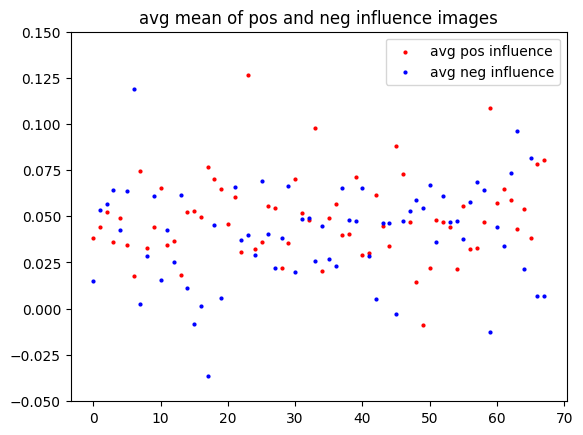

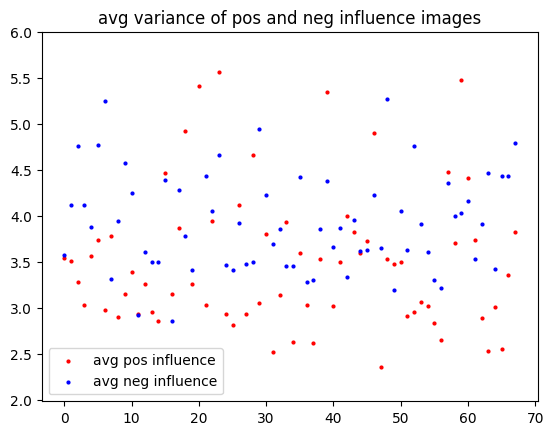

In [26]:
# pairs = [(5962,4),(29379,4),(29233,0),(29233,2),(36114,9),(45345,0), (23540,9),(43808,2),(15078,0)]
def plot_avg_mean():
    pos_means, neg_means = [], []
    n = len(influence_dic)
    for val_idx in influence_dic:
        pos_indices, neg_indices = influence_dic[val_idx]
        pos_mean, neg_mean = 0,0
        for idx in pos_indices:
            pos_mean += np.mean(score_T[idx,:])
        for idx in neg_indices:
            neg_mean += np.mean(score_T[idx,:])
        pos_means.append(pos_mean/len(pos_indices))
        neg_means.append(neg_mean/len(neg_indices))
    plt.scatter(range(n),pos_means,color='r',label='avg pos influence',s=4)
    plt.scatter(range(n),neg_means,color='b',label='avg neg influence',s=4)
    plt.title(f'avg mean of pos and neg influence images')
    plt.ylim(top=0.15)
    plt.legend()
    plt.show()
    
def plot_avg_var():
    pos_vars, neg_vars = [], []
    n = len(influence_dic)
    for val_idx in influence_dic:
        pos_indices, neg_indices = influence_dic[val_idx]
        pos_var, neg_var = 0,0
        for idx in pos_indices:
            pos_var += np.std(score_T[idx,:])**2
        for idx in neg_indices:
            neg_var += np.std(score_T[idx,:])**2
        pos_vars.append(np.sqrt(pos_var/len(pos_indices)))
        neg_vars.append(np.sqrt(neg_var/len(neg_indices)))
    plt.scatter(range(n),pos_vars,color='r',label='avg pos influence', s=4)
    plt.scatter(range(n),neg_vars,color='b',label='avg neg influence',s=4)
    plt.title(f'avg variance of pos and neg influence images')
    plt.ylim(top=6)
    plt.legend()
    plt.show()
    
def plot_diff():
    means, stds = [], []
    n = len(influence_dic)
    for val_idx in influence_dic:
        pos_indices, neg_indices = influence_dic[val_idx]
        pos_mean, neg_mean = 0,0
        pos_std, neg_std = 0,0
        for idx in pos_indices:
            pos_mean += np.mean(score_T[idx,:])
            pos_std += np.std(score_T[idx,:])
        for idx in neg_indices:
            neg_mean += np.mean(score_T[idx,:])
            neg_std += np.std(score_T[idx,:])
        means.append((pos_mean-neg_mean)/len(pos_indices))
        stds.append((pos_std/len(pos_indices)))
    plt.scatter(range(n),pos_means,color='r',label='avg pos influence',s=4)
    plt.scatter(range(n),neg_means,color='b',label='avg neg influence',s=4)
    plt.title(f'avg mean of pos and neg influence images')
    plt.ylim(top=0.15)
    plt.legend()
    plt.show()
    
plot_avg_mean()
plot_avg_var()



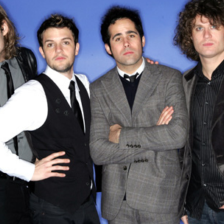

jeans


In [24]:
exp = 781275
display(transforms.ToPILImage()(ds_train[exp][0]))
print(labels[ds_train[exp][1]])